<a href="https://colab.research.google.com/github/thecodemancer/MachineLearning/blob/main/Modelo_de_predicci%C3%B3n_de_pr%C3%A9stamos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Modelo de Predicción (Clasificación) del estado de solicitudes de  Préstamos
 

### Introducción:

Este es un **problema de clasificación binaria** donde tenemos información sobre una muestra de solicitantes y necesitamos predecir si debemos otorgar o no un préstamo según dichos datos.

### Contenido

* **Visualización** de la data .
* **feature selection** y **feature engineering**   
* Algunas técnicas para **procesar** la data
* Manipulación de **missing data** .
* Manipulación de **datos categóricos** y **datos numéricos** .
* Detección de **outliers**
* **Evaluación** de modelo

### ¿Qué usaremos?

* Las siguientes librerías: **sklearn, matplotlib, numpy, pandas, seaborn, scipy**

* Llenar los valores utilizando **backward 'bfill' method** para columnas numéricas y **most frequent value** para  columnas categóricas.

* 4 modelos distintos para poder comparar:

    **a) logistic regression**
    
    **b) KNeighborsClassifier**
    
    **c) SVC**
    
    **d) DecisionTreeClassifier**
    
Aquí vamos

In [2]:
# Importamos librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount(mountpoint="/content/drive")

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/préstamos/train.csv')

# Exploratorio de la data


In [5]:
df.shape

(614, 13)

In [6]:
df.head()

#tenemos data categórica y su clasificación binaria, el estado (Y,N)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
df.info()

#tenemos data faltante. Se deberán tratar estos datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
# Describe (solo data numérica)

#df.describe(include='all')
df.describe()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
# vamos a cambiar el tipo de datos para Credit_History a object porque solo es 0 o es 1
df['Credit_History'] = df['Credit_History'].astype('O') #object

In [10]:
# describe data categórica ("object")

df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,564.0,614,614
unique,614,2,2,4,2,2,2.0,3,2
top,LP001002,Male,Yes,0,Graduate,No,1.0,Semiurban,Y
freq,1,489,398,345,480,500,475.0,233,422


In [11]:
#eliminamos Loan_ID porque es un correlativo. No es importante para nuestro modelo. Incluirlo puede llevarnos a conclusiones erróneas
df.drop('Loan_ID', axis=1, inplace=True)

In [12]:
df.duplicated().any()
#no tenemos filas duplicadas

False

El porcentaje de Y: 0.69
El porcentaje de N: 0.31


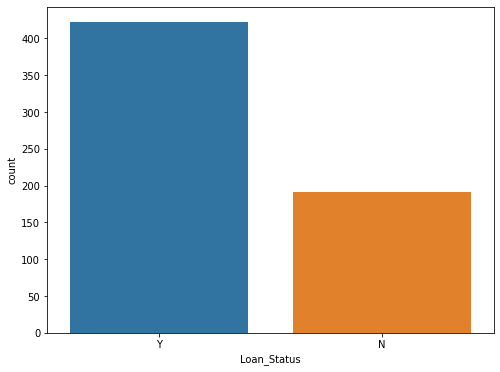

In [13]:
# Veamos los porcentajes de cada etiqueta

plt.figure(figsize=(8,6))
sns.countplot(df['Loan_Status']);

print('El porcentaje de Y: %.2f' % (df['Loan_Status'].value_counts()[0] / len(df)))
print('El porcentaje de N: %.2f' % (df['Loan_Status'].value_counts()[1] / len(df)))

# Observación: Tenemos poco más del doble de datos de solicitudes que fueron aceptadas que de las que fueron denegadas. 
# Esto se conoce como data desbalanceada y afecta la manera en que el modelo aprende. 

# Veamos de más cerca la data

In [14]:
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

### Primero iremos por las columnas o "features" categóricas


In [15]:
df.head(1)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


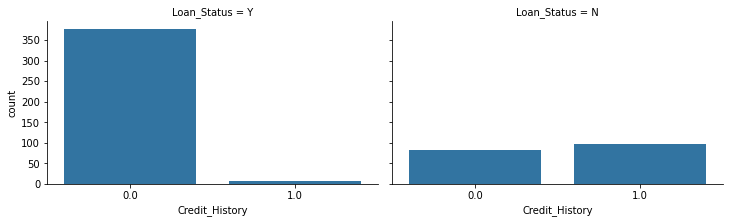

In [16]:
# Credit_History

grid = sns.FacetGrid(df,col='Loan_Status', size=3.2, aspect=1.6)
grid.map(sns.countplot, 'Credit_History');

# De los préstamos concedidos, la mayoría de solicitantes no contaba con historial crediticio (Credit History = 0)
# Pero no le concedimos el préstamo para la casi la misma cantidad de solicitantes con o sin historial crediticio
# Podemos decir que si el solicitante no tiene historial crediticio, tendrá más posibilidades de obtener el préstamo (¿?)
# Es un "feature" importante para este caso según la data

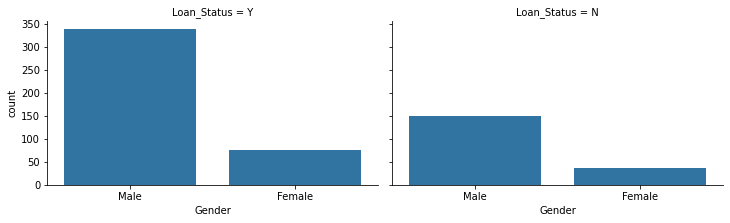

In [17]:
# Gender

grid = sns.FacetGrid(df,col='Loan_Status', size=3.2, aspect=1.6)
grid.map(sns.countplot, 'Gender');

# De los préstamos concedidos, la mayoría fue para solicitantes hombres
# De los préstamos no concedidos, la mayoría fue para solicitantes hombres
# ¿Es o no es un buen feature?


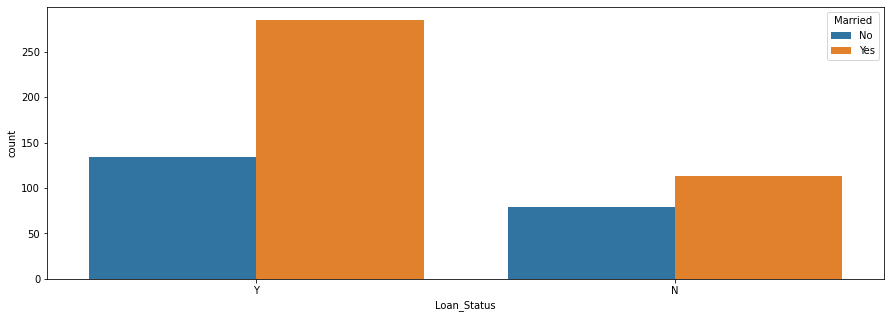

In [18]:
# Married
plt.figure(figsize=(15,5))
sns.countplot(x='Loan_Status', hue='Married', data=df);

# De los préstamos concedidos, la mayoría fue para solicitantes casados
# De los préstamos no concedidos, la mayoría fue también para solicitantes casados
# ¿Es o no es un buen feature?

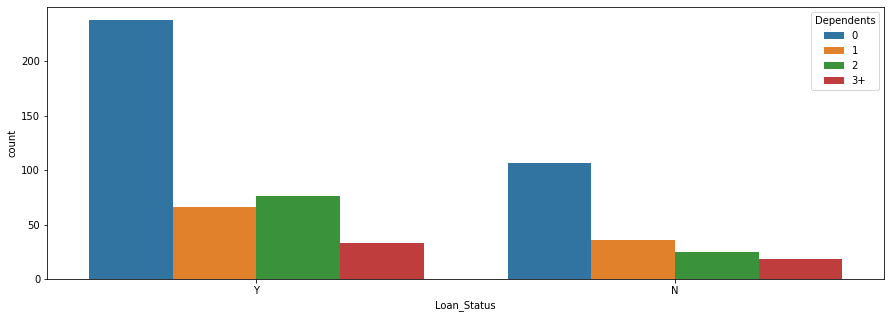

In [19]:
# Dependents

plt.figure(figsize=(15,5))
sns.countplot(x='Loan_Status', hue='Dependents', data=df);

# De los préstamos concedidos, la mayoría fue para solicitantes sin dependientes
# De los préstamos no concedidos, la mayoría fue también para solicitantes sin dependientes
# ¿Es o no es un buen feature?

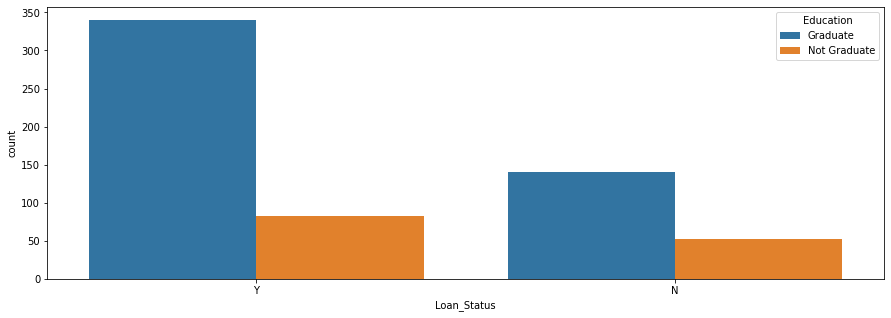

In [20]:
# Education

plt.figure(figsize=(15,5))
sns.countplot(x='Loan_Status', hue='Education', data=df);

# De los préstamos concedidos, la mayoría fue para solicitantes sin estudios
# De los préstamos no concedidos, la mayoría fue también para solicitantes sin estudios
# ¿Es o no es un buen feature?

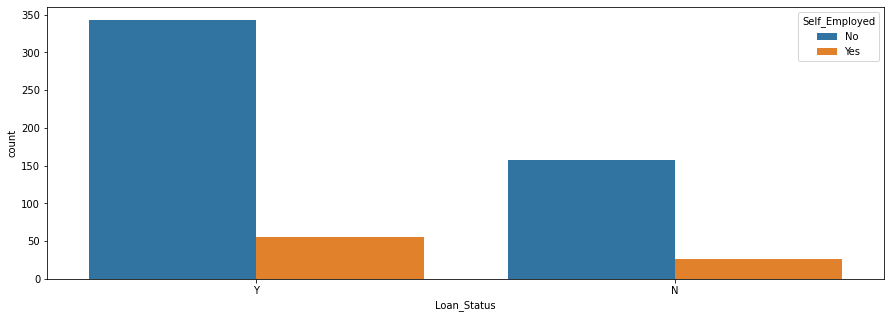

In [21]:
# Self_Employed

plt.figure(figsize=(15,5))
sns.countplot(x='Loan_Status', hue='Self_Employed', data=df);

# De los préstamos concedidos, la mayoría fue para solicitantes que no son independientes
# De los préstamos no concedidos, la mayoría fue también para solicitantes que no son independientes
# ¿Es o no es un buen feature?

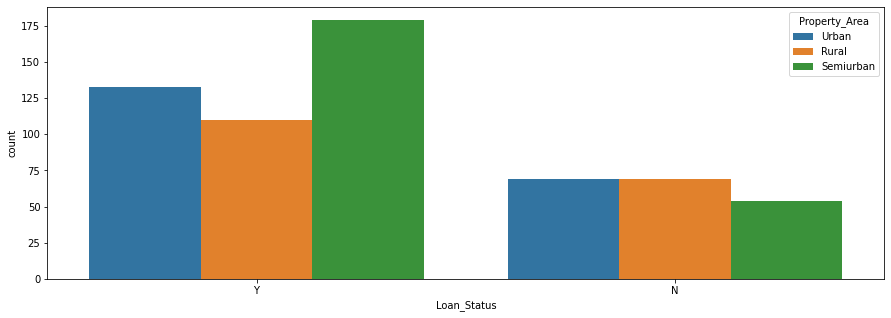

In [22]:
# Property_Area

plt.figure(figsize=(15,5))
sns.countplot(x='Loan_Status', hue='Property_Area', data=df);

# De los préstamos concedidos, la mayoría fue para solicitantes que tienen una propiedad de tipo 0 y 2
# De los préstamos no concedidos, la mayoría fue para solicitantes con una propiedad de tipo 1
# ¿Es o no es un buen feature?

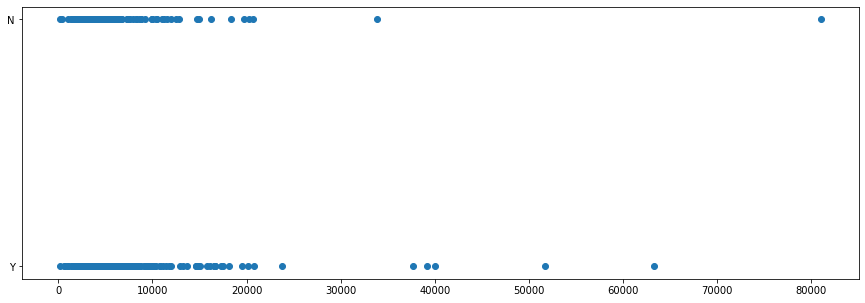

In [23]:
# ApplicantIncome
plt.figure(figsize=(15,5))
plt.scatter(df['ApplicantIncome'], df['Loan_Status']);

# Sin relación

In [24]:
# Los datos numéricos

df_loan_status_median = df.groupby('Loan_Status').median() # Aquí usamos la mediana porque no se ve afectada por outliers
df_loan_status_median

# Podemos decir que cuando tenemos una mediana baja en CoapplicantIncome no se nos concede el préstamo

# CoapplicantIncome es un buen "feature"

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
Loan_Status,,,,
N,3833.5,268.0,129.0,360.0
Y,3812.5,1239.5,126.0,360.0


# Procesado de la data

### Missing values

In [25]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [26]:
# Separamos la data numérica de la data categórica

cat_data = []
num_data = []

for i,c in enumerate(df.dtypes):
  print(c)
  if c == "object":
      cat_data.append(df.iloc[:, i])
  else :
      num_data.append(df.iloc[:, i])

object
object
object
object
object
int64
float64
float64
float64
object
object
object


In [27]:
cat_data = pd.DataFrame(cat_data).transpose()
num_data = pd.DataFrame(num_data).transpose()

In [28]:
cat_data.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,1.0,Urban,Y
4,Male,No,0,Graduate,No,1.0,Urban,Y


In [29]:
num_data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,5849.0,0.0,NaN,360.0
1,4583.0,1508.0,128.0,360.0
2,3000.0,0.0,66.0,360.0
3,2583.0,2358.0,120.0,360.0
4,6000.0,0.0,141.0,360.0


In [30]:
# cat_data
# Si quieres rellenar los missing values con el valor más frecuente (most frequent value), puedes ejecutar lo siguiente

cat_data = cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any() # False indica que no se tienen missing values

False

In [31]:
# num_data
# Si quieres rellenar los missing values con el valor
# fill every missing value with their previous value in the same column

num_data.fillna(method='bfill', inplace=True)
num_data.isnull().sum().any() # False indica que no se tienen missing values

False

### Columnas categóricas

* Aquí vamos a usar **LabelEncoder**. Este Encoder lo que hace es codificar etiquetas con valores entre 0 y el número de etiquetas menos 1 , [mayor detalle aquí](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) .

In [32]:
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder()
cat_data.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,1.0,Urban,Y
4,Male,No,0,Graduate,No,1.0,Urban,Y


In [33]:
# Transformar la variable objetivo

target_values = {'Y': 0 , 'N' : 1}

target = cat_data['Loan_Status']
cat_data.drop('Loan_Status', axis=1, inplace=True)

target = target.map(target_values)

In [34]:
# Transformar otras columnas

for i in cat_data:
    cat_data[i] = le.fit_transform(cat_data[i])

In [35]:
target.head()

0    0
1    1
2    0
3    0
4    0
Name: Loan_Status, dtype: int64

In [36]:
cat_data.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
0,1,0,0,0,0,1,2
1,1,1,1,0,0,1,0
2,1,1,0,0,1,1,2
3,1,1,0,1,0,1,2
4,1,0,0,0,0,1,2


In [37]:
df = pd.concat([cat_data, num_data, target], axis=1)

In [38]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,1,0,0,0,0,1,2,5849.0,0.0,128.0,360.0,0
1,1,1,1,0,0,1,0,4583.0,1508.0,128.0,360.0,1
2,1,1,0,0,1,1,2,3000.0,0.0,66.0,360.0,0
3,1,1,0,1,0,1,2,2583.0,2358.0,120.0,360.0,0
4,1,0,0,0,0,1,2,6000.0,0.0,141.0,360.0,0


# A entrenar!

Vamos a usar **StratifiedShuffleSplit**, que crea divisiones para cada etiqueta a predecir, preservando el mismo porcentaje que estos tenían en el conjunto completo. [Más información](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-shuffle-split).

![StratifiedShuffleSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0091.png)

In [39]:
X = pd.concat([cat_data, num_data], axis=1)
y = target 

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #n_splits: Número de barajas para dividir.

for train, test in sss.split(X, y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

# casi el mismo ratio
print('\nratio de la etiqueta en y_train :',y_train.value_counts().values/ len(y_train))
print('ratio de la etiqueta en y_test :',y_test.value_counts().values/ len(y_test))
print('ratio de la etiqueta en original_data :',df['Loan_Status'].value_counts().values/ len(df))

X_train shape (491, 11)
y_train shape (491,)
X_test shape (123, 11)
y_test shape (123,)

ratio de la etiqueta en y_train : [0.68635438 0.31364562]
ratio de la etiqueta en y_test : [0.69105691 0.30894309]
ratio de la etiqueta en original_data : [0.68729642 0.31270358]


In [41]:
# Usaremos 4 modelos distintos para entrenamiento
# Si el modelo lo soporta, usamos el mismo random_state para obtener la reproducibilidad de los resultados

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)
}

# Construcción de funciones

### vamos a construir 3 funciones :
1) **loss** : para evaluar los modelos
* [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* [f1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
* [log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
* [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

2) **train_eval_train** : para evaluar los modelos en la misma data en la que los entrenamos.

3) **train_eval_cross** : para evaluar los modelos usando diferente data que aquella utilizada para entrenarlos.
* [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

### ¿Por qué no entrenar los modelos y evaluarlos sin construir estas funciones? 

En realidad, puedes hacer eso, pero en general el modelo no funcionará bien al principio, por lo que debes cambiar algo sobre los datos para mejorar su precisión y en cada paso, debes evaluar el modelo para ver si está mejorando o no. Así que para no hacer este paso cada vez, estas funciones te facilitarán la vida a medida que avanzas :)

In [42]:
# loss

from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

def loss(y_true, y_pred, retu=False):
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    if retu:
        return pre, rec, f1, loss, acc
    else:
        print('  pre: %.3f\n  rec: %.3f\n  f1: %.3f\n  loss: %.3f\n  acc: %.3f' % (pre, rec, f1, loss, acc))

In [43]:
# train_eval_train

def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))
        print('-'*30)
        
train_eval_train(models, X_train, y_train)

# Observamos que el mejor modelo es _________________ al menos por ahora. 

LogisticRegression :
  pre: 0.930
  rec: 0.429
  f1: 0.587
  loss: 6.542
  acc: 0.811
------------------------------
KNeighborsClassifier :
  pre: 0.667
  rec: 0.364
  f1: 0.471
  loss: 8.863
  acc: 0.743
------------------------------
SVC :
  pre: 1.000
  rec: 0.013
  f1: 0.026
  loss: 10.692
  acc: 0.690
------------------------------
DecisionTreeClassifier :
  pre: 0.929
  rec: 0.422
  f1: 0.580
  loss: 6.612
  acc: 0.809
------------------------------


In [44]:
# SVC está haciendo "overfitting". 
# Es decir, está memorizando la data

In [45]:
X_train.shape

(491, 11)

In [46]:
# train_eval_cross

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

def train_eval_cross(models, X, y, folds):
    # Pasamos X & y a dataframe porque usaremos iloc (iloc no funciona con arrays de numpy)

    X = pd.DataFrame(X) 
    y = pd.DataFrame(y)
    idx = [' pre', ' rec', ' f1', ' loss', ' acc']
    for name, model in models.items():
        ls = []
        print(name,':')

        for train, test in folds.split(X, y):
            model.fit(X.iloc[train], y.iloc[train]) 
            y_pred = model.predict(X.iloc[test]) 
            ls.append(loss(y.iloc[test], y_pred, retu=True))
        print(pd.DataFrame(np.array(ls).mean(axis=0), index=idx)[0])  #[0] porque no queremos mostrar el nombre de la columna
        print('-'*30)
        
train_eval_cross(models, X_train, y_train, skf)

# Aquí se aprecia que DecisionTreeClassifier es mejor que LogisticRegression 
# cuando en el paso anterior era al revés LogisticRegression era mejor que DecisionTreeClassifier

LogisticRegression :
 pre     0.894048
 rec     0.422500
 f1      0.562733
 loss    6.752695
 acc     0.804490
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre      0.379834
 rec      0.207500
 f1       0.259954
 loss    12.381887
 acc      0.641510
Name: 0, dtype: float64
------------------------------
SVC :
 pre      0.000000
 rec      0.000000
 f1       0.000000
 loss    11.043955
 acc      0.680245
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.919048
 rec     0.422500
 f1      0.565740
 loss    6.611717
 acc     0.808571
Name: 0, dtype: float64
------------------------------


In [47]:
# Una explicación al paso anterior

x = []
idx = [' pre', ' rec', ' f1', ' loss', ' acc']

# Usaremos un modelo
log = LogisticRegression()

for train, test in skf.split(X_train, y_train):
    log.fit(X_train.iloc[train], y_train.iloc[train])
    ls = loss(y_train.iloc[test], log.predict(X_train.iloc[test]), retu=True)
    x.append(ls)
    
# Esto es lo que se obtiene
pd.DataFrame(x, columns=idx)

# (columna 0 representa el precision_score de los 10 folds)
# (fila 0 representa (pre, rec, f1, loss, acc) para el primer fold)
# entonces tenemos que hallar la media de cada columna
# pd.DataFrame(x, columns=idx).mean(axis=0)

,pre,rec,f1,loss,acc
0,0.875000,0.437500,0.583333,6.907771,0.800000
1,0.833333,0.333333,0.476190,7.753619,0.775510
2,0.875000,0.466667,0.608696,6.343873,0.816327
3,0.500000,0.200000,0.285714,10.573144,0.693878
4,1.000000,0.466667,0.636364,5.638984,0.836735
5,0.857143,0.400000,0.545455,7.048746,0.795918
6,1.000000,0.733333,0.846154,2.819492,0.918367
7,1.000000,0.625000,0.769231,4.229238,0.877551
8,1.000000,0.250000,0.400000,8.458476,0.755102
9,1.000000,0.312500,0.476190,7.753603,0.775510


# Mejorando el modelo

# feature engineering

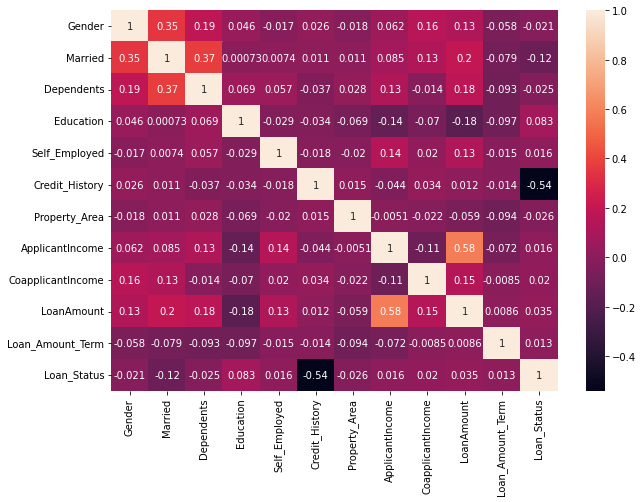

In [48]:
data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True);

# Observacions que de todos los features, Credit_History tiene la mayor correlación (negativa) con Loan_Status
# También observamos que existe un 0.58 de correlación entre LoanAmount & ApplicantIncome
# y eso puede ser malo para el modelo

In [49]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
415,0,0,0,0,0,1,2,2995.0,0.0,60.0,360.0
26,1,1,0,0,0,1,1,2799.0,2253.0,122.0,360.0
394,1,1,2,0,0,1,2,3100.0,1400.0,113.0,360.0
584,1,1,1,0,0,0,0,2787.0,1917.0,146.0,360.0
86,1,1,2,1,0,1,1,3333.0,2000.0,99.0,360.0


In [50]:
# Aquí se muestran, a manera de ejemplo, algunas operaciones que se pueden realizar con los features
# Tener experiencia en el sector y conocimiento sobre la data ayudan

X_train['new_col'] = X_train['CoapplicantIncome'] / X_train['ApplicantIncome']  
X_train['new_col_2'] = X_train['LoanAmount'] * X_train['Loan_Amount_Term'] 

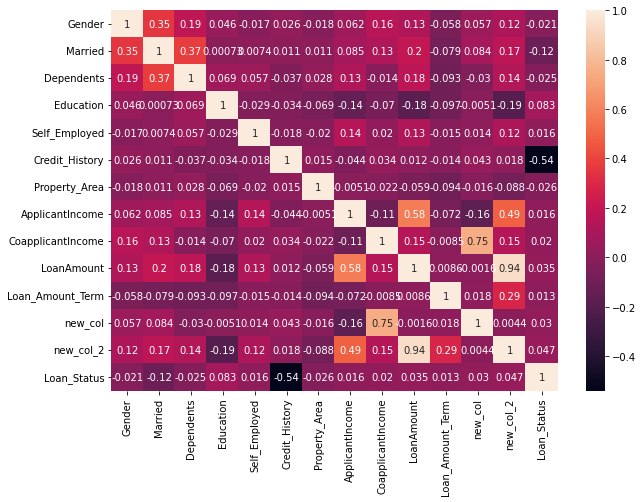

In [51]:
data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True);

# correlación con Loan_Status:
# new_col = 0.03 
# new_col_2= 0.047
# no es mucho pero nos ayudará a reducir el número de features

In [52]:
X_train.drop(['CoapplicantIncome', 'ApplicantIncome', 'Loan_Amount_Term', 'LoanAmount'], axis=1, inplace=True)

In [53]:
train_eval_cross(models, X_train, y_train, skf)

# SVC está mejorando pero LogisticRegression está haciendo overfitting
# Lo dejaremos así y veamos qué pasa

LogisticRegression :
 pre      0.000000
 rec      0.000000
 f1       0.000000
 loss    10.832488
 acc      0.686367
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre      0.313095
 rec      0.169167
 f1       0.218420
 loss    12.880939
 acc      0.627061
Name: 0, dtype: float64
------------------------------
SVC :
 pre      0.000000
 rec      0.000000
 f1       0.000000
 loss    10.832488
 acc      0.686367
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.919048
 rec     0.422500
 f1      0.565740
 loss    6.611717
 acc     0.808571
Name: 0, dtype: float64
------------------------------


In [54]:
# Primero miremos a los conteos de cada etiqueta
for i in range(X_train.shape[1]):
    print(X_train.iloc[:,i].value_counts(), end='\n------------------------------------------------\n')

1    398
0     93
Name: Gender, dtype: int64
------------------------------------------------
1    315
0    176
Name: Married, dtype: int64
------------------------------------------------
0    292
2     85
1     78
3     36
Name: Dependents, dtype: int64
------------------------------------------------
0    382
1    109
Name: Education, dtype: int64
------------------------------------------------
0    428
1     63
Name: Self_Employed, dtype: int64
------------------------------------------------
1    421
0     70
Name: Credit_History, dtype: int64
------------------------------------------------
1    179
2    170
0    142
Name: Property_Area, dtype: int64
------------------------------------------------
0.000000    222
0.414374      1
0.441544      1
0.556065      1
0.985459      1
           ... 
0.750075      1
0.964755      1
0.743616      1
5.365854      1
0.859254      1
Name: new_col, Length: 270, dtype: int64
------------------------------------------------
43200.0     18
3960

### Trabajaremos en los features que tienen valores variados

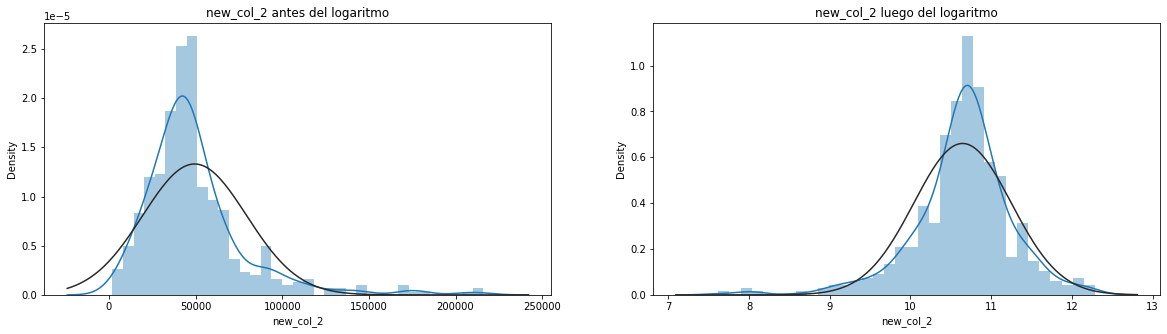

In [55]:
# new_col_2

# Vemos que se encuentra con un skew hacia la derecha
# Podemos resolver este problema con una simple técnica: Sacar logaritmos a todos los valores 
# Porque cuando la data se encuentra normalmente distribuida, hará que el modelo mejore

from scipy.stats import norm

fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.distplot(X_train['new_col_2'], ax=ax[0], fit=norm)
ax[0].set_title('new_col_2 antes del logaritmo')

X_train['new_col_2'] = np.log(X_train['new_col_2'])  # logaritmo de todos los valores

sns.distplot(X_train['new_col_2'], ax=ax[1], fit=norm)
ax[1].set_title('new_col_2 luego del logaritmo');

In [56]:
# Ahora vamos a evaluar los modelos
train_eval_cross(models, X_train, y_train, skf)

# Los modelos mejoraron bastante con solo ejecutar el paso anterior

LogisticRegression :
 pre     0.899048
 rec     0.429167
 f1      0.569764
 loss    6.611718
 acc     0.808571
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre     0.685278
 rec     0.336667
 f1      0.439734
 loss    8.860292
 acc     0.743469
Name: 0, dtype: float64
------------------------------
SVC :
 pre     0.811548
 rec     0.311667
 f1      0.444833
 loss    7.811411
 acc     0.773837
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.919048
 rec     0.422500
 f1      0.565740
 loss    6.611717
 acc     0.808571
Name: 0, dtype: float64
------------------------------


In [57]:
# new_col

# La mayoría de la data es 0, así que trataremos de cambiar cualquier otro valor distinto a 1

print('antes:')
print(X_train['new_col'].value_counts())

X_train['new_col'] = [x if x==0 else 1 for x in X_train['new_col']]
print('-'*50)
print('\nluego:')
print(X_train['new_col'].value_counts())

antes:
0.000000    222
0.414374      1
0.441544      1
0.556065      1
0.985459      1
           ... 
0.750075      1
0.964755      1
0.743616      1
5.365854      1
0.859254      1
Name: new_col, Length: 270, dtype: int64
--------------------------------------------------

luego:
1.0    269
0.0    222
Name: new_col, dtype: int64


In [58]:
train_eval_cross(models, X_train, y_train, skf)

LogisticRegression :
 pre     0.910714
 rec     0.422500
 f1      0.562606
 loss    6.682206
 acc     0.806531
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre     0.719762
 rec     0.298333
 f1      0.406231
 loss    9.074569
 acc     0.737265
Name: 0, dtype: float64
------------------------------
SVC :
 pre     0.819048
 rec     0.324167
 f1      0.458747
 loss    7.669026
 acc     0.777959
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.919048
 rec     0.422500
 f1      0.565740
 loss    6.611717
 acc     0.808571
Name: 0, dtype: float64
------------------------------


In [59]:
for i in range(X_train.shape[1]):
    print(X_train.iloc[:,i].value_counts(), end='\n------------------------------------------------\n')
    
# Se ve mejor

1    398
0     93
Name: Gender, dtype: int64
------------------------------------------------
1    315
0    176
Name: Married, dtype: int64
------------------------------------------------
0    292
2     85
1     78
3     36
Name: Dependents, dtype: int64
------------------------------------------------
0    382
1    109
Name: Education, dtype: int64
------------------------------------------------
0    428
1     63
Name: Self_Employed, dtype: int64
------------------------------------------------
1    421
0     70
Name: Credit_History, dtype: int64
------------------------------------------------
1    179
2    170
0    142
Name: Property_Area, dtype: int64
------------------------------------------------
1.0    269
0.0    222
Name: new_col, dtype: int64
------------------------------------------------
10.673596    18
10.586584    13
10.961278    11
10.491274    11
10.738134     9
             ..
11.643954     1
10.595634     1
9.856396      1
9.963641      1
12.100712     1
Name: new_

# Outliers

#### Existen diferentes técnicas para manejar outliers, aquí vamos a usar [**IQR (interquartile ranges)**](https://www.youtube.com/watch?v=qLYYHWYr8xI)

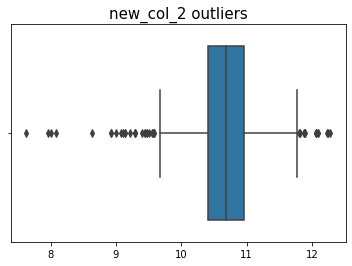

In [60]:
# Usaremos un gráfico de boxplot para detectar outliers

sns.boxplot(X_train['new_col_2']);
plt.title('new_col_2 outliers', fontsize=15);
plt.xlabel('');

In [61]:
threshold = 1.5  # este número es un hiperparámetro, mientras más lo reduces, más remueves data
                 # Puedes intentar con diferentes valores pero el que es por defecto (1.5) funciona bien para la mayoría de los casos
                 # No quieres intentar con un número muy pequeño porque podrías perder información importante de los datos.
                 
            
new_col_2_out = X_train['new_col_2']
q25, q75 = np.percentile(new_col_2_out, 25), np.percentile(new_col_2_out, 75) # Q25, Q75
print('Quartil 25: {} , Quartil 75: {}'.format(q25, q75))

iqr = q75 - q25
print('iqr: {}'.format(iqr))

cut = iqr * threshold
lower, upper = q25 - cut, q75 + cut
print('El Cut Off: {}'.format(cut))
print('Inferior: {}'.format(lower))
print('Superior: {}'.format(upper))

outliers = [x for x in new_col_2_out if x < lower or x > upper]
print('Número de Outliers: {}'.format(len(outliers)))
print('outliers:{}'.format(outliers))

data_outliers = pd.concat([X_train, y_train], axis=1)
print('\tamaño de X_train antes de eliminar outliers', len(data_outliers))
data_outliers = data_outliers.drop(data_outliers[(data_outliers['new_col_2'] > upper) | (data_outliers['new_col_2'] < lower)].index)

print('tamaño de X_train después de eliminar outliers', len(data_outliers))

Quartil 25: 10.416008100285975 , Quartil 75: 10.961277846683982
iqr: 0.5452697463980076
El Cut Off: 0.8179046195970114
Inferior: 9.598103480688962
Superior: 11.779182466280993
Número de Outliers: 39
outliers:[12.092679958175083, 8.930626469173578, 7.620705086838262, 12.254862809699606, 7.965545573129992, 9.574983485564092, 9.392661928770137, 9.578311275656766, 9.587406005562649, 9.112948025967533, 8.006367567650246, 9.144200569471638, 9.287301413112312, 9.441452092939569, 9.287301413112312, 12.059890135352092, 8.626944055375356, 9.51044496442652, 11.81569317484005, 9.441452092939569, 8.922658299524402, 9.287301413112312, 11.889991098556695, 12.059890135352092, 12.059890135352092, 12.231740392278752, 9.469622969906265, 9.137769679141348, 11.799607037088427, 9.084777149000837, 9.21830854162536, 8.99961934066053, 8.083328608786376, 12.283033686666302, 9.549665677579801, 11.877568578558138, 11.877568578558138, 12.100712129872347, 9.441452092939569]
	amaño de X_train antes de eliminar outli

In [62]:
X_train = data_outliers.drop('Loan_Status', axis=1)
y_train = data_outliers['Loan_Status']

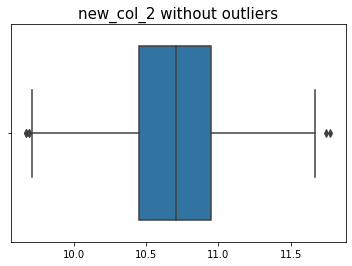

In [63]:
sns.boxplot(X_train['new_col_2']);
plt.title('new_col_2 without outliers', fontsize=15);
plt.xlabel('');

# mejor :)

In [64]:
train_eval_cross(models, X_train, y_train, skf)

LogisticRegression :
 pre     0.907500
 rec     0.442857
 f1      0.587307
 loss    6.423889
 acc     0.814010
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre     0.755873
 rec     0.342857
 f1      0.459636
 loss    8.341061
 acc     0.758502
Name: 0, dtype: float64
------------------------------
SVC :
 pre     0.643333
 rec     0.235714
 f1      0.340616
 loss    8.406109
 acc     0.756618
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.920833
 rec     0.442857
 f1      0.589413
 loss    6.347135
 acc     0.816232
Name: 0, dtype: float64
------------------------------


# features selection

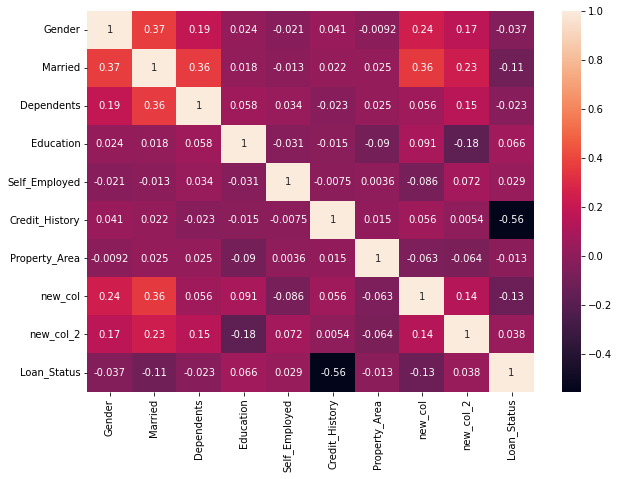

In [65]:
# Self_Employed obtuvo una correlación muy baja, intentemos quitarla y veamos qué pasa

data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True);

In [66]:
X_train.drop(['Self_Employed'], axis=1, inplace=True)

train_eval_cross(models, X_train, y_train, skf)

# parece que Self_Employed no es importante
# KNeighborsClassifier mejoró

# puedes intentar eliminar el restor de features a excepción de Credit_History y ver si los modelos cambian
# Inténtalo pero no te olvides de hacerlo en los datos de testing

#X_train.drop(['Self_Employed','Dependents', 'new_col_2', 'Education', 'Gender', 'Property_Area','Married', 'new_col'], axis=1, inplace=True)

LogisticRegression :
 pre     0.907500
 rec     0.442857
 f1      0.587307
 loss    6.423889
 acc     0.814010
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre     0.764275
 rec     0.385714
 f1      0.500336
 loss    7.957299
 acc     0.769614
Name: 0, dtype: float64
------------------------------
SVC :
 pre     0.920833
 rec     0.414286
 f1      0.563958
 loss    6.650809
 acc     0.807440
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.920833
 rec     0.442857
 f1      0.589413
 loss    6.347135
 acc     0.816232
Name: 0, dtype: float64
------------------------------


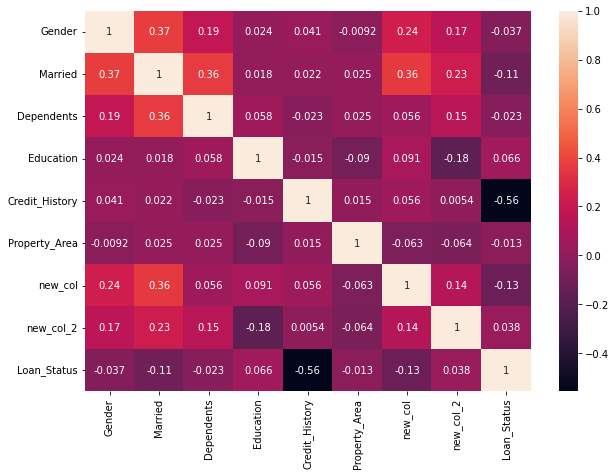

In [67]:
data_corr = pd.concat([X_train, y_train], axis=1)
corr = data_corr.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True);

# Evaluar los modelos en la data de testing

Aquí vamos a repetir lo que hicimos con la data de training

In [68]:
X_test.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
182,1,1,0,0,0,1,1,4600.0,0.0,73.0,180.0
440,1,0,0,0,0,1,1,3660.0,5064.0,187.0,360.0
276,1,1,0,0,0,1,1,3993.0,3274.0,207.0,360.0
533,1,0,1,0,0,1,1,11250.0,0.0,196.0,360.0
504,1,1,0,1,0,1,1,3814.0,1483.0,124.0,300.0


In [69]:
X_test_new = X_test.copy()

In [70]:
x = []

X_test_new['new_col'] = X_test_new['CoapplicantIncome'] / X_test_new['ApplicantIncome']  
X_test_new['new_col_2'] = X_test_new['LoanAmount'] * X_test_new['Loan_Amount_Term']
X_test_new.drop(['CoapplicantIncome', 'ApplicantIncome', 'Loan_Amount_Term', 'LoanAmount'], axis=1, inplace=True)

X_test_new['new_col_2'] = np.log(X_test_new['new_col_2'])

X_test_new['new_col'] = [x if x==0 else 1 for x in X_test_new['new_col']]

X_test_new.drop(['Self_Employed'], axis=1, inplace=True)

# Eliminar todos los features a excepción de Credit_History
#X_test_new.drop(['Self_Employed','Dependents', 'new_col_2', 'Education', 'Gender', 'Property_Area','Married', 'new_col'], axis=1, inplace=True)

In [71]:
X_test_new.head()

,Gender,Married,Dependents,Education,Credit_History,Property_Area,new_col,new_col_2
182,1,1,0,0,1,1,0.0,9.483416
440,1,0,0,0,1,1,1.0,11.117213
276,1,1,0,0,1,1,1.0,11.218823
533,1,0,1,0,1,1,0.0,11.164219
504,1,1,0,1,1,1,1.0,10.524064


In [72]:
X_train.head()

,Gender,Married,Dependents,Education,Credit_History,Property_Area,new_col,new_col_2
415,0,0,0,0,1,2,0.0,9.980449
26,1,1,0,0,1,1,1.0,10.690125
394,1,1,2,0,1,2,1.0,10.613492
584,1,1,1,0,0,0,1.0,10.869711
86,1,1,2,1,1,1,1.0,10.481224


In [73]:
for name,model in models.items():
    print(name, end=':\n')
    loss(y_test, model.predict(X_test_new))
    print('-'*40)

LogisticRegression:
  pre: 0.850
  rec: 0.447
  f1: 0.586
  loss: 6.739
  acc: 0.805
----------------------------------------
KNeighborsClassifier:
  pre: 0.652
  rec: 0.395
  f1: 0.492
  loss: 8.705
  acc: 0.748
----------------------------------------
SVC:
  pre: 0.889
  rec: 0.421
  f1: 0.571
  loss: 6.739
  acc: 0.805
----------------------------------------
DecisionTreeClassifier:
  pre: 0.895
  rec: 0.447
  f1: 0.596
  loss: 6.458
  acc: 0.813
----------------------------------------


**Conclusión:**

Vemos que los scores cambian al realizar transformaciones sobre los features. Es importante tener conocimiento del sector y de los datos con los que se está trabajando